# DL-Final | Analogy Generation




This project uses code from [Rey Farhan](http://reyfarhan.com/about/). Some code comments are from the original author.

#Fine-tune with Huggingface 

## Setup

Load all of our libraries and packages

In [ ]:
!pip install transformers
!pip install wandb
!python -m spacy download en_core_web_md

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import json

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
from nltk.corpus import wordnet
from itertools import chain

nltk.download('punkt')

import en_core_web_md
import requests 



In [ ]:
!nvidia-smi

In [ ]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'dl'")
filename = 'dummy.json'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


## Create Training Set

The data used to finetune the language model is a set of around 50,000 words and definitions, with the goal of generating definitions in the same style later on.

In [ ]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [ ]:
# load into a data frame
df = pd.read_json(filename)  
print(df)

In [ ]:
df.rename(columns={'def': 'defs'}, inplace=True)
df.dropna(inplace=True) #remove NA values
defs = df.word.copy()+ ": " + df.defs.copy() #just use the main bio text in this example
defs

In [ ]:
doc_lengths = []

for definition in defs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(definition)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

In [ ]:
np.average(doc_lengths)

## GPT2 Tokenizer


We use the standard GPT-2 Tokenizer and specify the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


## PyTorch Datasets & Dataloaders


Limiting the batch size to 2 since GPT2 model is large and can lead to memory problems.

In [ ]:
batch_size = 2

Create a dataset class to load the data and pass the tokenizer as an argument.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

Set the definition max length to 768 tokens.

In [ ]:
dataset = GPT2Dataset(defs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,000 training samples
1,000 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
# default parameters

epochs = 6
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

Train over 6 epochs.

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  4,500. Loss: 0.09217902272939682.   Elapsed: 0:00:29.
0:  bipartisanbicycle. See Bicycle, Bicycle, Bicycle, Bicycle, Bicycle or Bicycle. The Bicycle, Bicycle or Bicycle; Bicycle, Bicycle, Bicycle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  4,500. Loss: 0.5883630514144897.   Elapsed: 0:00:58.
0:  increasinginhibitory: A condition for which an individual is guilty only of being anhibitory; a condition which is used for causing or producing the perception or feeling of things that are not in order: an action of discharging.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  4,500. Loss: 0.15310172736644745.   Elapsed: 0:01:28.
0: dayal the second set of the first set.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  4,500. Loss: 0.09529107809066772.   Elapsed: 0:01:57.
0:  Hangoutate is with a the mind; a. In and an, the result to be, as the water." to any of the eye; to make a as the other a man. the purpose; a of course of the state.) the, to gain, or an other, -- a. To pass of the manner, is it, to work of the one in the work, it for your future name."
 the future, to the tree of a man by the a time. the tree. a candle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  4,500. Loss: 0.10526144504547119.   Elapsed: 0:02:27.
0:  foodsfian or of their, as, etc.
a. [a"s.) "A. (Obs.), 2.
 (1) 1. A. In the last body of any kind of the time, or a good quality of being a horse.) -- to run from the last aspect of an estate; also, so, etc.. 2.1. 2. [Obs.] B. L. A. The same person of the army; 3. E. And a-penser. "1. The title of a father and his power; as) in a line or several things; or an object which is probably from heaven; in time and, as for; as the eye on, for time; as the, to become as are the name of the use of the way of a kind-1. -- as will do too a time or was in its time of the same in the first thing used, as on the time; -- in.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  4,500. Loss: 0.07575208693742752.   Elapsed: 0:02:58.
0:  traildignoid: [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  4,500. Loss: 0.10485677421092987.   Elapsed: 0:03:27.
0: intendsubcontaining to be given a piece of paper, or an instrument, used for the printing of paper, which is not in circulation, or as, a receptacle for the printing of paper, and a form for making bazoned paper. The final product for printing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  4,500. Loss: 1.6027103662490845.   Elapsed: 0:03:56.
0:  surroundmoorin: Any person or woman with a moor or moor..... Moorin.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  4,500. Loss: 0.19193296134471893.   Elapsed: 0:04:25.
0:  reflexpierches: A line, line, lines, or lines drawn by a pen or pencil, which lines or lines, or lines drawn with pens and pencil, through a pen-clothed or cartilaginous ink. Macaulay.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  4,500. Loss: 0.05867976322770119.   Elapsed: 0:04:55.
0:  displaysugot: 1. The sum of all several kinds; as, the sugot of the dog; nautilus. 3. The sugot of the stag. Shak.

To sugot a sugot.

To have been sugot. [Obs.] 4. --sugot of the tard, the sugot of the dog.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  4,500. Loss: 0.2420305758714676.   Elapsed: 0:05:24.
0:  pastorharrulous: (a) The quality or state of being harrulous; a harrulous. -- The quality or state of being harrulous. -- Inharrulous; harrulous. -- Harrulous; harrulous; harrious.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  4,500. Loss: 0.3080412447452545.   Elapsed: 0:05:54.
0:  illicitprodificant: Pertaining to a series of diseases, including Crops, Inflammation, or inflammation, caused by inflammation, inflammation, or inflammation of inflammation, or inflammation of lymphæ.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  4,500. Loss: 0.13053719699382782.   Elapsed: 0:06:23.
0:  Liberationbephalon: The stately, lively song of Marthalk.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  4,500. Loss: 0.136468306183815.   Elapsed: 0:06:52.
0:  Namlangi, A woman born of this language, who was born in dothraul; as also I was my lord and I was my wife. I heard thy Grace say. Shak. Jer. xxi. 22. It I had been the wife of the Lord, and my wife was her mother. I saw her dothrae. Jonson.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  4,500. Loss: 0.7937229871749878.   Elapsed: 0:07:22.
0: IONhorsen: 1. A place where you may go to have the first horsen. 2. (Chem.)  A compound or compound, containing a derivative, consisting of Horsens, or of hydrogen gas, and having the second hydrogen gas gas, which is obtained by the decomposition of a gas and oxidation of coal. 3. (Chem.)  A compound or compound of hydroxy hydrogen, obtained by fusion or fusion of three hydrogen atoms. The result is Horsens. 4. (Chem.)  The action of a hydrogen gas on a mineral, a solid, or a pure gas, as made by fusion or fusion, and the action of hydrogen, by fusion, by boiling. -- The action of gas on bodies. 5. (Chem.) The action of Horsens. 6. (Mil.)  A chemical gas by which it is mixed, as Horsens, and the chemical gas is made. 7. A mixture, consisting of H


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  4,500. Loss: 0.12895168364048004.   Elapsed: 0:07:52.
0:  glimpsesea: The sea; a sea for light.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  4,500. Loss: 0.21441982686519623.   Elapsed: 0:08:21.
0:  Lauredisfranchising: Becoming unable to separate, or to form, the substance of, the substance of any one substance; unable to separate or separate from, another.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  4,500. Loss: 0.21095150709152222.   Elapsed: 0:08:51.
0: ismcouculy: Of or pertaining to couculy; pertaining to couculy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  4,500. Loss: 0.2694780230522156.   Elapsed: 0:09:20.
0: ountuberose: The brownish grayish black-black of his skin; as, tuberose, tuberose blue, grayish blue; tuberulated. Bornee.

To tuberose; to brownish; as, tuberosa.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  4,500. Loss: 0.16109569370746613.   Elapsed: 0:09:49.
0:  electionspit: 1. To paint or join with a thing in place. See Spits. Spitting, Spitting, Spitting;Spits. 2. To cause to come or end to take or take off, or to be brought in place. 3. To give notice to another; to give notice of another. In addition to a thing in place of a thing in front of it, or to take off or take off, such that they will take one as soon as we take one, as the earth is rolling in such an action.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  4,500. Loss: 0.14729751646518707.   Elapsed: 0:10:19.
0:  crazywicksett: The wickset of the American Indians; a horse wicksett.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  4,500. Loss: 0.18363337218761444.   Elapsed: 0:10:48.
0:  benchscatterby: A place where the people scatter; as, this house scatterby the grass; the house scatterby-beet, a kind of fruit scatterby-beet on a field; -- applied to the animals.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  4,500. Loss: 0.24602946639060974.   Elapsed: 0:11:18.
0:  incorporatedinstrumentality: Usefulness; quality; efficacy; quality. [R.] Dryden.

A quality; state of being instrumentality; instrumentality.

Instrumentality, as of an instrumentality, an instrumentality, a instrumentality, an instrumentality, the instrumentality, an instrumentality, and a instrumentality.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  4,500. Loss: 0.20784127712249756.   Elapsed: 0:11:47.
0: Petercronical: A division of fishes including the larva and littæ. See Carboniferous.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  4,500. Loss: 0.12302599847316742.   Elapsed: 0:12:16.
0: uringsaurist: One who practices the healing of fishes, and used for holding the fingers under.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  4,500. Loss: 0.5429947972297668.   Elapsed: 0:12:45.
0:  reproductivedactyoid: One of those small cells which receive the electricity from plants; -- called also cytiotidina and cytiotinidina.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  4,500. Loss: 0.6254130601882935.   Elapsed: 0:13:14.
0:  zonelucidation: The act or process of producinglucin or urethone; glucoid.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  4,500. Loss: 0.053014565259218216.   Elapsed: 0:13:44.
0:  commitswhim: A faggy fellow, a kind of whine or whiner.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  4,500. Loss: 0.29127317667007446.   Elapsed: 0:14:13.
0:  ironyantagile: Of or pertaining to the Antagiles.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  4,500. Loss: 0.09377342462539673.   Elapsed: 0:14:42.
0:  Sahvistaceous: Of or pertaining to a vistaceous mineral.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  4,500. Loss: 0.24920335412025452.   Elapsed: 0:15:11.
0:  Bryanlargeness: The quality or state of being atrocious; barbarism; barbarism; barbarism; barbarism; barbarism; barbarism; barbarism; barbarism.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  4,500. Loss: 0.99693763256073.   Elapsed: 0:15:40.
0:  spiritsreliable: Reliable. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  4,500. Loss: 0.21850015223026276.   Elapsed: 0:16:09.
0:  seeswailer: A flounder; a fox; a fox.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  4,500. Loss: 0.2253248244524002.   Elapsed: 0:16:38.
0:  hungrysassette: A cassock.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  4,500. Loss: 1.4540784358978271.   Elapsed: 0:17:07.
0:  PTcantantagous: 1. Not connected with, or possessed of by, one; -- opposed to cantagæ and cantagæ-pisæ. The sanguine character of the cantagæ-pisæ. Sir W. Scott. 2. Unconstructed. [Obs.] "A cantagæs" n., n., 3. 3. Not of a species; hence, not in a sense of the plural. "Cantagæ*phyryomy is a disease." Chaucer. 4. A general disease; a disease disease. See Antagæ-phyry. -- Cantagæ-phyomy is called the Cantagæ-phyry; Cantagæ-phyery is called Cantagæ-myogy. See Chancre-Med.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  4,500. Loss: 0.0724821463227272.   Elapsed: 0:17:37.
0: ütidal: See Tidal.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  4,500. Loss: 0.2227608561515808.   Elapsed: 0:18:06.
0: rucequodene: (a) A short, slender, slender stem in the central spine of a gourd beetle. (b) A short, slender, slender tree (A. nigritum) in Southern Europe. It feeds on berries.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  4,500. Loss: 0.10324794799089432.   Elapsed: 0:18:36.
0:  derivativesquinquefefefefe: The quinquefefeeal.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  4,500. Loss: 0.4340536296367645.   Elapsed: 0:19:05.
0: fibula: A tribe of plants (Fibula fibula) resembling the Fibula family of plants, found at the disposal of the fibula. They are now called Fibula fibula, and are sometimes called Fibula fibula. See Fibula, under Fibula.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  4,500. Loss: 0.7044418454170227.   Elapsed: 0:19:34.
0:  rememberingbauge: Same as Beauge.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  4,500. Loss: 0.4607539176940918.   Elapsed: 0:20:03.
0:  Sourceshept: 1. The pauper. [Obs.] Sir. W. Scott. 2. (Her.)  A kind of glass glass, usually blue or white, made of zinc oxide, and usually blue iron to keep from scratches or scratches, as by the action of heat or cold; a light glass.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  4,500. Loss: 0.5839081406593323.   Elapsed: 0:20:33.
0: emsclotter: One who clots clotters.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  4,500. Loss: 0.09431282430887222.   Elapsed: 0:21:02.
0: tzlittant: Serving as a lathe or machine. See lathe, n.

To bring lathe upon; to produce lathes in; to manufacture lathes. [Obs.]
Founding lathes in; especially, as lathe of wood, and lathe of oil.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  4,500. Loss: 0.1673475205898285.   Elapsed: 0:21:31.
0: maticdrowse: To wash away; to destroy; to burnished; to extinguish. Cowper.

  Average training loss: 0.32
  Training epoch took: 0:22:00

Running Validation...
  Validation Loss: 0.27
  Validation took: 0:00:47

======== Epoch 2 / 6 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  4,500. Loss: 0.2502455413341522.   Elapsed: 0:00:29.
0:  syndunderground: Furnished with a hole or holes, or in front of, a surface in the surface.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  4,500. Loss: 0.12748070061206818.   Elapsed: 0:00:58.
0:  gamlucidize: To makewe or I think. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  4,500. Loss: 0.11160575598478317.   Elapsed: 0:01:27.
0:  injurymulked: That mutilated with a butcherish ulcer. Grafton.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  4,500. Loss: 0.9084945321083069.   Elapsed: 0:01:56.
0: azapinkering: The act or process of making or producing by means of money; as, money was one of the pinkering of the Bankruptcy stock market.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  4,500. Loss: 0.38089609146118164.   Elapsed: 0:02:25.
0:  membranegrambon: A genus of liliaceous flowers.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  4,500. Loss: 0.7130181789398193.   Elapsed: 0:02:54.
0: ijingsensorship: The state of being sensitized to taste.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  4,500. Loss: 0.06095567345619202.   Elapsed: 0:03:23.
0:  castreformative: Of or pertaining to reformism or religion.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  4,500. Loss: 0.10596321523189545.   Elapsed: 0:03:52.
0:  purchintervalency: The quality of being intervaluated by, or by the nature of, intervalency.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  4,500. Loss: 0.13005633652210236.   Elapsed: 0:04:22.
0:  shouldersintermodal: Intermodal in relation; intermodal.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  4,500. Loss: 0.17872852087020874.   Elapsed: 0:04:51.
0:  builtpipel: To make a kind of short rope. Spenser.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  4,500. Loss: 0.12883387506008148.   Elapsed: 0:05:20.
0:  openlyprolatous: Bearing the sentiments of, or as characteristic of, a man or of another; as, the laws of some States." Locke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  4,500. Loss: 0.13584373891353607.   Elapsed: 0:05:49.
0:  haltedmummers: 1. The people that mummyers are found. 2. mummymerds. [Zoöl.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  4,500. Loss: 0.0628802478313446.   Elapsed: 0:06:18.
0:  Nikstirler: 1. One who stirs up; a person who stirs up; a stirler. A stirler who stirs. Shak. 2. The person who stirs up, or stirs up. The stirler who stirs up a stirler. Milton.

To stir up; to stir up in stirles; to stir. I will stir up and stirs in a stirler's voice. Gen. xxviii. 5, 6.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  4,500. Loss: 0.1151081770658493.   Elapsed: 0:06:48.
0:  tinquota: 1. A quantity in the form of a quota. 2. (Sig.) (a) A figure for representing that quantity by a quantity called the quota. SeeQuota.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  4,500. Loss: 0.3872515857219696.   Elapsed: 0:07:17.
0:  clinicalsigmostichordid: Having a siphichord or siphichordid.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  4,500. Loss: 0.14125923812389374.   Elapsed: 0:07:46.
0: lectionshippophthalmia: 1. Want of hearing; -- applied to birds with acute hearing, as distinguished from ordinary hearing. 2. Hence: A slight tingling, or noise of thunder. 3. (Med.)  The tingling of the blood or of blood; as, anippophthalmia of the venere.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  4,500. Loss: 0.5453051328659058.   Elapsed: 0:08:16.
0: elsplaggerer: One who writes in book, or the like.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  4,500. Loss: 0.20632033050060272.   Elapsed: 0:08:45.
0: labunstrat: Of or pertaining to obstruction; as, unstrat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  4,500. Loss: 0.06570428609848022.   Elapsed: 0:09:14.
0:  triplem: A narrow m; a narrow m. [R.] Fuller.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  4,500. Loss: 0.14941886067390442.   Elapsed: 0:09:43.
0: 220frozentery: A treatise.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  4,500. Loss: 0.0865088701248169.   Elapsed: 0:10:12.
0:  Seeclotted: imp. of Clevegled; curved; as, a clotted leaf.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  4,500. Loss: 0.46462467312812805.   Elapsed: 0:10:41.
0: @@tannage: To introduce. [Obs.] Chaucer. Tannage, that all our sorrows and our sorrows pass with the good of another. "Tannaged with the effects of the sea." Chaucer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  4,500. Loss: 0.25167593359947205.   Elapsed: 0:11:10.
0:  hostfluxation: The act of gathering, or the state of being collected, so as to make up in a mass of metal, the appearance of the metal being changed by the combined effort of ore, and thus produced a sudden reduction in the proportion of the material used in the combustion engine; especially, a proportion greater than the combined effort required to collect the metal or other material.

1. To collect ore. 2. To collect or powder; to draw off; to send from a source; hence, to give to a deposit; hence, to impart. An object may be used more than as it seems to take. Bower.

1. To collect out; to be supplied with ore; to make up. An object is filled with gas or gas which becomes gas, and the gas gas is forced out of its normal state. 2. To treat or make out or impart, as of gas or of some other substance; as, the alcohol is concentrated upon


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  4,500. Loss: 0.19569745659828186.   Elapsed: 0:11:41.
0: rolecantaculum: A large part of the pantaculum, like the long, slender, hemispherical fibers, which cover the sieve's mouth, and in the form of hemispherical teats (called also aceticular cordage, etc.) the membrane walls of which the pearly cordage is held.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  4,500. Loss: 0.12156647443771362.   Elapsed: 0:12:10.
0: iacwort: A genus of herbs, mostly in Europe, having a short, slender pod. [Written also wort, wort, wort, wort.]

A herbaceous shrub (Avesia pustulee, or the like) resembling the wort, but with a long, slender pod, or twigs, with a small, florets. (Naut.) An herbaceous plant (Avesia purpurea, or the like) containing the wort, and with short, florets, of the woodpecker woodpecker (Avesia pustulara) bearing a wort, or wort, and with short, spines, or tufts of the handle, or barbs of a wort, or other substance or substance of a wort, -- used in drawing hay, or feeding hay, grain, or grain. [Prov. Eng. & Scot. & Scot.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  4,500. Loss: 0.17061655223369598.   Elapsed: 0:12:41.
0:  LDmisfic: Not bearing a fine or soft substance; not soft; soft; soft; soft. Bacon. -- Mun"mi"tic*ly, adv.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  4,500. Loss: 0.09755221009254456.   Elapsed: 0:13:10.
0:  Listencrisaceous: Of or pertaining to the crissæ of fishes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  4,500. Loss: 0.16015945374965668.   Elapsed: 0:13:39.
0:  dyunneat: Not neat. [Obs.] Bacon.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  4,500. Loss: 0.055913738906383514.   Elapsed: 0:14:08.
0:  Domestictobacco: 1. One who, or that which, habitually or habitually. 2. A medicine used in reducing or giving out an effusion. 3. A medicine used in treating diseases as with poison. Sir W. Raleigh. 4. A medicine used in treating diseases as poison, or in reducing diseases as with poison, or in curing diseases. 5. A medicine for smoking. 2. One affected with, or addicted to, tobacco; a pipe that becomes addicted.acco habit, the habit of tobacco. -- Tobacco habit, the habit and manner of tobacco. -- Tobacco habit, the habit habit, the habit of tobacco in any disease. -- Tobacco habit, the habit used in curing diseases, or in treating diseases. -- Tobacco habit, the habit, the habit, and the habit of smoking. -- Tobacco habit, one of the habit. -- Tobacco habit, the habitually; habitually, a habit. -- Tobacco habit, one of the habit of tobacco


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  4,500. Loss: 0.3762633204460144.   Elapsed: 0:14:39.
0:  beneficiarieseuchiniferous: Bearing or growing to the state of being Euchinoideous.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  4,500. Loss: 0.09999869018793106.   Elapsed: 0:15:08.
0:  Titletruvie: (a) The European titmouse; (b) the European titmouse. (c) The European titmouse. (d) The European titmouse.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  4,500. Loss: 0.8802337646484375.   Elapsed: 0:15:37.
0:  μdispassioned: 1. Having the right or dignity of a second or last moment; disquiets. [R.] That duke, duke of my country, disquiets it. Spenser. 2. Implying or causing to change from the customary order or form. "Disquiets him, so late to this degree." Milton.

1. A change in time; a change of place or time; a change of direction. The duke and his squires... a change of time. Spenser. 2. A change of place or direction; change of composition; change of composition.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  4,500. Loss: 0.16206195950508118.   Elapsed: 0:16:08.
0:  sellingcrenulated: 1. Fully laid; -- also said of persons; specifically, in the United States; -- usually followed by with after. 2. Causing; producing; making a cause; causing; as, one's cause to go. 3. Causing; as, the cause of causes. 4. Implying; yielding; yielding; yielding; yielding; yielding; yielding; yielding; yielding; yielding.

1. A person yielding or yielding to a principle or model, or to the authority of others; one who, or that which, yieldss or yieldss. 2. A cause laid. 3. (Law)  A disposition or disposition that, on principle, a cause, does not rise to any party; hence, the cause of any cause or cause or cause, whether caused by a cause, and occasion, to be decided, or laid out of the party or cause, and therefore, whether it does rise in a cause and cause;


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  4,500. Loss: 0.11492422223091125.   Elapsed: 0:16:38.
0:  migrantdissimilarist: A person who favors or believes in a matter to be of equal to the truth; one who holds or forms an essay, a written and directed to be revealed in court for his allegediary, or a declaration of his intention to seek the truth. Syn. -- Displying.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  4,500. Loss: 0.12193259596824646.   Elapsed: 0:17:08.
0: ivelycouscovet: One of the two species.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  4,500. Loss: 0.09786529093980789.   Elapsed: 0:17:37.
0:  orderunipatry: The act of separating or dividing from aipatry. [R.] Sir T. Herbert.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  4,500. Loss: 0.08006186783313751.   Elapsed: 0:18:06.
0:  VPNunbip: See Bunke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  4,500. Loss: 0.09641111642122269.   Elapsed: 0:18:35.
0:  explanationintelligential: Not intelligential; as, the intelligential pronoun.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  4,500. Loss: 0.11709766089916229.   Elapsed: 0:19:04.
0:  Bachfirmable: Capable of being established.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  4,500. Loss: 0.5159206986427307.   Elapsed: 0:19:33.
0:  folderscum: A deposit of liquid from an earthy formation, in which a small portion of a rock is found, in the rocks; as, the Silurite; the Rock Silurite. [Formerly written Scot.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  4,500. Loss: 0.06105080246925354.   Elapsed: 0:20:02.
0:  buildinggum: 1. (Zoöl.)  Any one of numerous species of East Indian chæpanopterous fishes of the family Silica, allied to the sea-jack. The gums often have a yellowish, black-colored body, but the male is usually a whitish, yellowish body. Note: The gums are related to the East Indies, but have a very important distinction of the genus Silica. The gums are allied to the common gums. Called also gums. 2. (Gram.)  A little words of the Greek and Greek. See the Note under Alphabet under Alphabet.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  4,500. Loss: 0.09334822744131088.   Elapsed: 0:20:32.
0:  Babylonbism: 1. A system of doctrines, principles, principles, and principles expressed by faith, or by the principles of some belief. 2. A system of principles or principles expressed by religious principles, esp. by opinions of government or a party for living reform; hence, a system of opinions; a system of principles or principles; a system; an absolute system of principles or opinions, esp. principles of one person, of a party or party for holding on a principle of living reform. A system of laws is opposed to the principles of the system of politics. Locke. 3. The principles of an argument; a system of principles; as, the principles of politics or the principles of a party. 3. Hence, the principles of a system of principles, principles, etc. 4. (Philos.)  A system of principles or principles, which expresses a system of principles or principles, or of a system of ideas, or of principles or principles; he

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  4,500. Loss: 0.1518903374671936.   Elapsed: 0:21:03.
0: perialbless: To call a bless. [R.] Spenser.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  4,500. Loss: 0.25925421714782715.   Elapsed: 0:21:32.
0:  rentsexoplasm: The formation of the inner wall of anything to cover the ground of a country or country, and cause its inhabitants to lodge in country or city.

  Average training loss: 0.24
  Training epoch took: 0:22:01

Running Validation...
  Validation Loss: 0.28
  Validation took: 0:00:47

======== Epoch 3 / 6 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  4,500. Loss: 0.07386506348848343.   Elapsed: 0:00:29.
0:  Regfantasm: A disease characterized by its rapid development.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  4,500. Loss: 0.1447903960943222.   Elapsed: 0:00:58.
0: olasdissimilar: 1. (Med.)  The operation of changing into dissimilar substance, in which one disease is treated with a fever. 2. (Med.)  The operation or course of the fever which causes the fever; a fever which attends in the course of the disease, which often causes persons affected with various kinds of fever which are characterized by the dizziness and shrinking of the blood vessels which are associated with the fever which is characterized by a fever which causes the fever; -- called also diagnificaissimilar fever.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  4,500. Loss: 0.1539667844772339.   Elapsed: 0:01:28.
0:  responsesstany: 1. (Chem.)  A crystalline semitransparent salt of stany, obtained from coal tar, obtained from coal tar, wood tar, etc. 2. (Min.)  A salt of stany. [Prov. Eng.] It has been called stany salt. It is related to stany chloride by reason of the impurities which constitute this salt. See Stany salt, below. 3. The fine, or fine, of coal tar. 4. Anything stany. [Obs.] Bacon. Stany salt (Chem.), salt of stany and iron tar.

1. To have stany, as of stany, stany, stany, stanyite, stany, stanyite, stany salt. [Obs.] 2. To crystalline; to stain. [Obs.] A kind of silver stany solution made of wood tar. [Colloq. S.] Thacker.

1.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  4,500. Loss: 0.10699933022260666.   Elapsed: 0:01:59.
0:  attendancescratch: 1. To pick apart and separate, as wood, bone, cartilage, or foot, from; to select. The scratch and clover. Mrs. Browning. 2. To separate or remove completely from the scratch of; as, to scratch a book with a pen. 3. To select one's own scratch. And with scratch, And with scratch with a needle. Cowper.

To pick apart from the scratch, as wood. [R.] Shak.
To pick a scratch with; to pick out the scratch of.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  4,500. Loss: 0.4841306209564209.   Elapsed: 0:02:29.
0:  rigiddawl: A short piece or piece.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  4,500. Loss: 1.0343899726867676.   Elapsed: 0:02:58.
0: grogribblet: A compact or loose, long hair or coarse hair or hair. [Written also gribblet.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  4,500. Loss: 0.1365550011396408.   Elapsed: 0:03:27.
0:  Gredisgend: To divest of, as a bird. Shak.

1. To divest of, as a bird; to deprive of, as a bird. 2. To divest of, as from a bird; to deprive of, or from, the fiber of. The fibers of the goose were disgend in their sockets. Chaucer. 3. To divest from a form of gendarm; to give no proof. Sir W. Raleigh. 4. To give up by nongend; to strip; to absolve. [Obs.] "I'm no less.. to have, I'll have to disgend." Spenser. 5. To give up; to make disjointed; to discard the fibers or fibers of a bird or of its natural possessions; hence, to free from having been taken. 6. To loose from confinement or restraint, and leave to run loose from one place; to release; to release from restraint from confinement;


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  4,500. Loss: 1.0304659605026245.   Elapsed: 0:03:58.
0: uraanteutical: Of or pertaining to an adjeutical or treatment.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  4,500. Loss: 0.14434508979320526.   Elapsed: 0:04:27.
0:  2020encycogen: An an extinct division of Arachis, an arachis, Arachis torquatus, Arachis retifera, Arachis tunifera, Arachis trematodea, Arachis agaulis, Arachis tunata, and Arachis violacea, alligator. -- Encycogenes (Gypæl.), a Brazilian plant of the genus Sthenospores, formerly known as an encycogen.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  4,500. Loss: 0.1077200174331665.   Elapsed: 0:04:57.
0:  charginghippose: Same as Hippochrone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  4,500. Loss: 0.10975085943937302.   Elapsed: 0:05:26.
0:  Sarbromine: To clear from a tube or aperture, as a sponge shell, esp. a sponge shell, often used to remove pressure and hence for maintaining an pressure, as a sponge shell. It has a thick, reddish crystalline structure of a pearly rhombohedral substance, formed by deposition from the interior of the invertebrate coral, thus formed by deposition from the interior of the lobster.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  4,500. Loss: 0.13529522716999054.   Elapsed: 0:05:55.
0:  Jascoppie: To take profit of (a coöper).


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  4,500. Loss: 0.06115693971514702.   Elapsed: 0:06:24.
0:  permitdew: To cut off or clear; to wipe. Dryden.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  4,500. Loss: 0.0950993075966835.   Elapsed: 0:06:53.
0:  Administratorcuboisy: A cubical, roundabout, or bedpan used in drawing cubi by the cutting tool. Note: The cubi of a capacious tree is the sum of the cubi. The cubi of a flem, the common cubi of a flem, are nearly equal to the cubi. The cubi of a tree.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  4,500. Loss: 0.17241771519184113.   Elapsed: 0:07:23.
0:  EVENTSunquiet: 1. A state of being disturbed. Bp. Hall. 2. Unlawful or impeded privacy. [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  4,500. Loss: 0.19051632285118103.   Elapsed: 0:07:52.
0:  Mentalexpertus: See Accule.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  4,500. Loss: 0.05928463116288185.   Elapsed: 0:08:21.
0: idsstigmata: A division of Coleoptera, including the workers, as well as the many others.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  4,500. Loss: 0.048194706439971924.   Elapsed: 0:08:50.
0: ceansdichlamytheides: A genus of trees, such as the American wintergreen, the American wintergreen, and the European wintergreen. They are perennial of the species Chamoecyparis, and are used as trees for its fruit. The branches also carry about the length. (see Chamoecyparis). See Chamoecyparis.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  4,500. Loss: 0.12139761447906494.   Elapsed: 0:09:20.
0:  geneticallyquitted: Pertaining to, or attributed to, the quits of the Bible; as, the quits of the Bible; also, applied to things, to persons, or their appetites; quits. Quits of faith, Quits of sin. Locke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  4,500. Loss: 0.05202335864305496.   Elapsed: 0:09:49.
0:  advicesoda: 1. The sac; a scapula. 2. (Zoöl.)  The calcum of the sea urchins.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  4,500. Loss: 0.147036612033844.   Elapsed: 0:10:18.
0:  incompletekantian: Of or pertaining to theanskrit language, or to any of the language spoken by the Druids, or an Asiatic variety of the Asiatic sect.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  4,500. Loss: 0.04471834748983383.   Elapsed: 0:10:48.
0: commentliquefid: Of or pertaining to a small piece of land in England, the first of the six hills on a coast of England, now with English, North, and South America; as, a limestone springs on a ledge of water; a well-known cement. Liquefid rock is a kind of slate, of the same type, used to propel water in highways. The name is also applied in other respects to the rock of the first magnitude in the Triassic. Liquefid sand, salt salt, etc., are prepared from the salpet, which is used for cement lime, cement, or cement; and lime varieties are prepared from lime- lime, lime- lime, lime- alum, lime- lime- lime- lime, lime- rock, limestone, lime- rock lime- stone, etc.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  4,500. Loss: 0.12589429318904877.   Elapsed: 0:11:18.
0:  pilotwail-sterned: Dull; stupid; dull; stupid. "A wail-sterned villain." Shak.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  4,500. Loss: 0.20455192029476166.   Elapsed: 0:11:47.
0: gerscacodylic: A system of compounds for producing calcareous tubers, tubers, etc.; calcareous.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  4,500. Loss: 0.10483337938785553.   Elapsed: 0:12:17.
0:  mutationpermitting: 1. That is said of a thing, not of itself, but that which has been said, or that has been spoken; that is, the denial of the guilt of the crime of a crime. 2. That has been done in wrong or wrong; as, the denial of one's faith or of a good offer. 3. (Law)  The act of denial; as, the denial of a crime or conviction of crime; the denial of a crime committed with malice. Bouvier. 4. (Law)  The act, process, or cause by which certain kinds of property, be limited by the act of malicious falsehood or slander.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  4,500. Loss: 0.07876358926296234.   Elapsed: 0:12:47.
0:  Driverpigma: A genus of trees, including the pea tree (Ptero album) and the thrysweet (Polycella glaceæ) of Europe, much used for ornamental furniture and furniture for furniture; -- called also figma bark.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  4,500. Loss: 0.6192131042480469.   Elapsed: 0:13:16.
0: itiself-asserting: Having a claim to claim a real right; real; real; -- opposed to self-asserting, or self- explaining. Self-asserting falsehood (See under Self-asserting).


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  4,500. Loss: 0.04531890153884888.   Elapsed: 0:13:45.
0: fffturbigo: A group of poisonous substances found in the U States. They are regarded as a yellowish crystalline substance.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  4,500. Loss: 0.1210881695151329.   Elapsed: 0:14:15.
0: riminationfibula: 1. (Zoöl.)  A genus of transparent, handsomely transparent, transparent, transparent- colored, reticulated frobs and branched frobs. 2. (Zoöl.)  An transparent, transparent-colored fruit or flower found on the tubercles of many species.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  4,500. Loss: 0.03528263792395592.   Elapsed: 0:14:44.
0: aquespial: A member of a compound sect sect or society, as the sect of Mohammedans, especially those attended the school of Mohammedans. [Formerly also spial.] [Written also spial.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  4,500. Loss: 0.08768970519304276.   Elapsed: 0:15:13.
0: leedisfact: To run away or away. [Obs.] Sir W. Scott.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  4,500. Loss: 0.054797668009996414.   Elapsed: 0:15:42.
0:  Alzheimerbereaver: One who bereaves or makes off his own estate; one who bereaves himself; one who bereaves his estate. Blackstone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  4,500. Loss: 0.7022534608840942.   Elapsed: 0:16:12.
0:  checkingsteree: A small pond of water at the mouth of a river; -- originally much used as a harbor. In water the steree is used, and as a blandishing or blandishing.

To let in the mouth, by means of a blow, as a blow of a piece of wood, by a blow of a hand, etc.; to make a sound; to sound with sound; to make a sound with. He would hardly give any distinction to these objects, nor to his own words. Shak.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  4,500. Loss: 0.05985255539417267.   Elapsed: 0:16:42.
0: nesiumpondel: A pessary mammal (Gastrus), having the anterior legs unfinished; -- so named by the supposed authors of J. Herschel, a German writer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  4,500. Loss: 0.11358289420604706.   Elapsed: 0:17:11.
0:  1957supervivivis: One of the spaces between villein and villein of the sphere (of a great circle of a) or in a space between villein and zille, for a space or space, as between two planets, or at right angles of each side, or between any two planets or planets, or between two planets each other; as, the heavens appear also to a constriction in the sphere between planets and planets.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  4,500. Loss: 0.2899194657802582.   Elapsed: 0:17:41.
0: manshipslaggy: Rascally peasy. Shak. -- Sarc"dled*ly, adv. -- Sarc"dled*ness, n.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  4,500. Loss: 0.47447824478149414.   Elapsed: 0:18:10.
0:  understandcope: A telescope. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  4,500. Loss: 0.045230284333229065.   Elapsed: 0:18:39.
0:  passionchapfallen: Somewhat exhausted of snow; -- with out and in. "Atched to chapfallen walls." Keats.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  4,500. Loss: 0.12051581591367722.   Elapsed: 0:19:08.
0:  curvedmisee: See Misee. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  4,500. Loss: 0.06773000210523605.   Elapsed: 0:19:37.
0:  Ansapient: 1. Given to sleep; as, sapient sleep. 2. Sleepy; restless. " sapient dankton." Boyle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  4,500. Loss: 0.09587094187736511.   Elapsed: 0:20:06.
0: ottidissilient: Deprived of substance; dewed; dried and impregnated with salt; as, dry salts are deluded, and are not dioxindol, but by heat and dryness.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  4,500. Loss: 0.18209299445152283.   Elapsed: 0:20:36.
0:  intakespathulate: Having a slender, irregular, usually hard and stiff, segment, or fissure. It is very common in both animal and vegetable animals.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  4,500. Loss: 0.07194098085165024.   Elapsed: 0:21:05.
0:  Tsfissile: Of or pertaining to the Fissile formation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  4,500. Loss: 0.1431002914905548.   Elapsed: 0:21:34.
0:  Mainmetacrometer: Same asMetacrometer.

  Average training loss: 0.20
  Training epoch took: 0:22:03

Running Validation...
  Validation Loss: 0.28
  Validation took: 0:00:47

======== Epoch 4 / 6 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  4,500. Loss: 0.04648968204855919.   Elapsed: 0:00:29.
0:  temnauseary: See Nauseary.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  4,500. Loss: 0.4749308228492737.   Elapsed: 0:00:58.
0:  Clickstethoscopist: An examiner for the use of spectrum analysis.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  4,500. Loss: 0.11339535564184189.   Elapsed: 0:01:27.
0:  XVtussis: One of the troops formed in the trenches, by which the armies were amalgamated and their companies into the trenches.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  4,500. Loss: 0.16933651268482208.   Elapsed: 0:01:56.
0:  dormimperviable: Not pervious; impervious. [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  4,500. Loss: 0.31871992349624634.   Elapsed: 0:02:25.
0:  upstreamliquefiable: Liquefiable. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  4,500. Loss: 0.08984146267175674.   Elapsed: 0:02:54.
0: الconterminal: Between the middle or central ducts of a vessel; convexal. Burrill.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  4,500. Loss: 0.28405261039733887.   Elapsed: 0:03:23.
0: ariascandless: Having no teeth; -- applied to birds that have no teeth.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  4,500. Loss: 0.04321557283401489.   Elapsed: 0:03:52.
0: PGkettledrum: A transverse, four-masted vessel, usually laden with parchment, for preparing the interior of the keel or the lower part of the keel.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  4,500. Loss: 0.2967534065246582.   Elapsed: 0:04:22.
0: Illimminutionary: 1. Expressed to, or produced, impudence; having power to measure; hence, impudent. Johnson. 2. (Law)  Fitted to, or characterized by, impudence; as, an impudent law, law, or the like; impudent in substance to a charge or indictment; as, an impudent document.

To prepare, as a document, into the form of a charge or process, as a charge, or a charge.

Impudence; impudence.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  4,500. Loss: 0.046032410115003586.   Elapsed: 0:04:52.
0:  automatedgarrulus: The external region of the stomach or intestines, including in the anterior region the intestines and intestines.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  4,500. Loss: 0.03973107039928436.   Elapsed: 0:05:21.
0:  hiringunobedible: Not obedible. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  4,500. Loss: 0.09854964166879654.   Elapsed: 0:05:50.
0:  tweetingself- knowledge: Knowledge of one's self; consciousness of one's self; consciousness of one's self. [Obs.] Bacon.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  4,500. Loss: 0.08372961729764938.   Elapsed: 0:06:19.
0: abitligneous: Made of wood; resembling wood; -- used figuratively for wood that has been taken from the wood; as, a ligneous wood. Ligneous marble. (Geol.) See under marble.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  4,500. Loss: 0.059779584407806396.   Elapsed: 0:06:48.
0:  iireclining: 1. Exceeding new limits; not old. I may never have borne your testimony before the court. Bp. Hall. 2. Constituting newness or newness; as, a new year or reëcated day. 3. Exceedingly old or too old; beyond the original; as, a new year; new years. Those new year renewing old women that breathe new joyously are dead. Blackstone. 4. Changing by regular steps or orderly succession; as, a new course of action or consequence; as, a new course of learning. 5. Capable of being changed or improved. Newly beginning at the new period, with which new year it was forced to retire. Addison. Note: The word new denotes newness, and newness of character; newness of time. Syn. -- Augment; newness; newness; newness; newness. See Augment.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  4,500. Loss: 0.044999826699495316.   Elapsed: 0:07:19.
0: clipmohr: One of the Mahrattas.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  4,500. Loss: 0.04791712388396263.   Elapsed: 0:07:48.
0:  Francincommunicable: Not yet capable of being mentioned.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  4,500. Loss: 0.06460748612880707.   Elapsed: 0:08:17.
0:  listeningstirrer: One who stirnies. [R.] Sir T. Browne.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  4,500. Loss: 0.12212414294481277.   Elapsed: 0:08:46.
0:  EUtollarck: A kind of yellowish crystalline substance formed from the union of tollusks; -- called alsoollarck brown, green, and brownish gray.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  4,500. Loss: 0.14996883273124695.   Elapsed: 0:09:15.
0:  incrediblepalmaceous: Of or pertaining to palms; of the nature of, or resembling, palms.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  4,500. Loss: 0.05630362033843994.   Elapsed: 0:09:44.
0:  TYfalsity: The quality or state of being fellible.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  4,500. Loss: 0.3325095474720001.   Elapsed: 0:10:13.
0:  230plumbeous: Characteristic of, or containing, plums; consisting of plumbeous; as, plumbeous beds.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  4,500. Loss: 0.038651350885629654.   Elapsed: 0:10:43.
0:  Tigersanastrophe: Anrophe, or part of a word, formed from an empty space, but not dependent on the action of compasses; as, ananrophe to a verse; ananastrophe to a verb.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  4,500. Loss: 0.342169851064682.   Elapsed: 0:11:12.
0: CDfrenzied: Affected with frenzy; frantic; impetuous. With frenzied eyes. Pope.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  4,500. Loss: 0.1449960321187973.   Elapsed: 0:11:41.
0:  unbelievablelithocarp: An instrument for determining the amount of matter separated from the blood; a lymphatic.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  4,500. Loss: 0.03638899326324463.   Elapsed: 0:12:10.
0: Robertdiscoid: Having the rays of light which produce red rays. Discoid lamp (Opt.), a lamp specially adapted to producing luminous rays, as a mirror in which the rays are concentrated by reflectors which produce red rays.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  4,500. Loss: 0.22387921810150146.   Elapsed: 0:12:40.
0:  Contactvacuum: 1. A place, a place, or a portion of a body, near a central place or object, along which the object is laid. The space was a v Vacuum at sea between London and the Holy Ghost, all the great sea being in sight of the divinity at once. Macaulay. 2. The sea; the ocean. 3. (a) (Astron.) A small space, usually called the "Book of the Cucubalus." It was the place of the great vacuum of the west side of the United States. It was the locke for the junction of the two continents. In this v Vacuum it is the land of the great vacuum of the sea, and with its shorter side and furrows lying against each other. Hence, it is the place of an island or part of a city or other country; it is the place of a vacuum (called the European vacuum);


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  4,500. Loss: 0.1732574999332428.   Elapsed: 0:13:10.
0:  fountainantithesis: The doctrine or belief of the gods (called by his followers), as opposed to the formal religion; pantagraphics; pantagraphics.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  4,500. Loss: 0.21943256258964539.   Elapsed: 0:13:40.
0:  clashbronchic: Bronchial.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  4,500. Loss: 1.0292502641677856.   Elapsed: 0:14:09.
0:  commodphagma: A genus of sand grouse (Syrrghaptes). The species (S. gracilis) inhabits the mountains of Asia and the west of Europe. Note: They make their own nests in twigs and twigs, and turn into twigs when they turn in spring; as, the gentleman-and-eagle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  4,500. Loss: 0.2434319406747818.   Elapsed: 0:14:38.
0:  algorithmthespian: Same as Same as Thespian.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  4,500. Loss: 0.5988883972167969.   Elapsed: 0:15:07.
0:  accuratepontocracy: Government by all its attendant attendant attendant, or its highest court, allure and regulate its affairs.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  4,500. Loss: 0.17752061784267426.   Elapsed: 0:15:36.
0: adoliquefaction: The act of liquiting. [Obs.] Bailey.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  4,500. Loss: 0.05419918894767761.   Elapsed: 0:16:05.
0:  regulatetrama: A bad state of the body, in which its functions are strained; malusory, or convulsed, in parts.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  4,500. Loss: 0.040552496910095215.   Elapsed: 0:16:35.
0: ewaymowen: A cow.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  4,500. Loss: 0.07309611141681671.   Elapsed: 0:17:03.
0: itteefibula: A genus of palms (Fibula arvense) having pendulous leaves in each pistil; the solitary, or simple, type.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  4,500. Loss: 0.06148494407534599.   Elapsed: 0:17:33.
0:  Jackiediprismatic: Characterizing, or illustrating, dips and fatty degeneration of the epidermis.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  4,500. Loss: 0.13243333995342255.   Elapsed: 0:18:02.
0: Hebrontometer: An instrument for noting phenomena in thunderstorms.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  4,500. Loss: 0.11751950532197952.   Elapsed: 0:18:31.
0:  wiredcirrhaphy: A disease characterized by inflammation and ulceration, as inrhaphy of the lung, or by convulsions; a chronic inflammation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  4,500. Loss: 0.09173453599214554.   Elapsed: 0:19:00.
0:  frequconvictive: Convincing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  4,500. Loss: 0.3253674805164337.   Elapsed: 0:19:29.
0:  viewsspotted: Spotted in the nose, as many other insects. They usually have the nose covered with a quills. Called also sand fly (Zoöl.), and webworm.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  4,500. Loss: 0.12716731429100037.   Elapsed: 0:19:58.
0:  Strategydisunite: To link or disconnect. [Obs.] Spenser.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  4,500. Loss: 0.03661752864718437.   Elapsed: 0:20:27.
0:  radiorinkery: The act, process, or art, of dressing with the hands of animals.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  4,500. Loss: 0.10178524255752563.   Elapsed: 0:20:56.
0: oultcrispate: 1. (Bot.)  Growing on, or in the state of, several plants; as, craspida, pectoralis, corolla, linnæ, and linnæ; craspida. 2. (Zoöl.)  Producing, or causing, a sensation of weariness or weariness; -- said of various plant membranes which are developed on the skin of certain species, and also of its color; as, the craspida of the female bud; craspida of a cotton plant.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  4,500. Loss: 0.08416067808866501.   Elapsed: 0:21:27.
0:  Reinmisrecite: To recite erroneously; to misrecite.

1. To recite erroneously. 2. To rehearse.

  Average training loss: 0.15
  Training epoch took: 0:21:56

Running Validation...
  Validation Loss: 0.30
  Validation took: 0:00:48

======== Epoch 5 / 6 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  4,500. Loss: 0.03893577307462692.   Elapsed: 0:00:29.
0:  procproditory: Pertaining to, or formed by, preliminary instruction; introductory to a natural or conventional method; as, a proditory note; proditory note. Owen. Proditory part (Gram.), the part joining the forefoot in front of the foot. Syn. -- introductory; instructing; exing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  4,500. Loss: 0.0669478252530098.   Elapsed: 0:00:59.
0:  abusessophism: The practice of snuffing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  4,500. Loss: 0.09714921563863754.   Elapsed: 0:01:28.
0:  wafissiparism: Reproduction by spontaneous fission. Fissiparism is a puritan of spontaneous fission. Hammond.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  4,500. Loss: 0.04077393189072609.   Elapsed: 0:01:57.
0: lectedvaudeville: A lively dance characterized by a rapid turn of the foot of a violin, and accompaniment by a rapid succession of successive movements.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  4,500. Loss: 0.03946777805685997.   Elapsed: 0:02:26.
0:  templelosingly: In a manner to incur loss.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  4,500. Loss: 0.19481173157691956.   Elapsed: 0:02:55.
0:  lodlacteously: Livelihood. [Obs.] Bp. Hall.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  4,500. Loss: 0.09576500207185745.   Elapsed: 0:03:24.
0:  Rioparapetite: A fossil millepore. See Illusts. of Marsh.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  4,500. Loss: 0.520736813545227.   Elapsed: 0:03:53.
0:  Penceepistolize: To write epistles.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  4,500. Loss: 0.05547013133764267.   Elapsed: 0:04:22.
0:  Stevenshafted: Shaped like the head of an ax; blunt.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  4,500. Loss: 0.08890806138515472.   Elapsed: 0:04:51.
0:  discoursealveatedly: In a beehive manner.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  4,500. Loss: 0.02537612058222294.   Elapsed: 0:05:20.
0:  accessoryzooeloger: One who zoöps, or makes use of, zoöps; a zoölogist.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  4,500. Loss: 0.029895896092057228.   Elapsed: 0:05:49.
0: ullutingosperm: Any plant of the family Tabanidæ, as the resinous, acrid, sulphuric, and dandelion. Note: They have five membranous flowers, with two gills, with a row of flat petals, and are used as an in medicine, in dehydration, and in general. In many of the saline plants, the name is sometimes given to those compounds of the proper chemical group which are really called palmitides. See sensitis.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  4,500. Loss: 0.06289651244878769.   Elapsed: 0:06:19.
0:  slidingscratcher: One who, or that which, scratches.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  4,500. Loss: 0.11921124160289764.   Elapsed: 0:06:48.
0:  Dellcliffler: 1. One who holds or practices a story; a story; a gossip. [Obs.] B. Jonson. 2. One who is very familiar with nature and humor; a glazier; an old dotard; a dolt Dryden. He begins his story in a very tender and serious way. Hawthorne.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  4,500. Loss: 0.105262391269207.   Elapsed: 0:07:18.
0: iusinapprehensive: Not apprehensive; inapprehensive; impetuous. -- In`ap*se"tious*ness, n.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  4,500. Loss: 0.7415872812271118.   Elapsed: 0:07:47.
0: sidedbendingly: In a foolish manner.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  4,500. Loss: 0.05175377428531647.   Elapsed: 0:08:16.
0:  WPbendhol: A kind of glass, made of a thick pasteboard shell of the Pacific Ocean, into which are heated and exposed to intense heat. -- Buddha"hol`i*dcs.t.  A bendhol species (Tropidorhynchus shipwreck) from California to Oregon.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  4,500. Loss: 0.05294854938983917.   Elapsed: 0:08:45.
0:  exertclik: See Cleavers.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  4,500. Loss: 0.21244953572750092.   Elapsed: 0:09:14.
0: inianpockery: 1. A pockish clown. "Pockery snake." B. Jonson. 2. A tall, handsome American snake (Syrrghaptes). It lives in the mountains of Southern Asia, feed on carrion and other flesh. Called also charlock, king snake, and bear snake.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  4,500. Loss: 0.04032403975725174.   Elapsed: 0:09:44.
0:  electricitysemi-pelagianism: The doctrines of the Semi-Pelagians.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  4,500. Loss: 0.04428480565547943.   Elapsed: 0:10:13.
0:  Aviationanabranchisement: The act of abertaining.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  4,500. Loss: 0.048231061547994614.   Elapsed: 0:10:42.
0:  encodingpaedogenesis: Reproduction by young or larval animals of the age or early dotard years.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  4,500. Loss: 0.09943827241659164.   Elapsed: 0:11:11.
0: fitdivertive: 1. Tending to divert; diverting; diverting; diverting; as, a diverting wind; a diverting motion; a diverting bill or stream; a diverting cambrian. 2. Tending to divert; diverting; diverting; diverting. [R.] Evelyn. Syn. -- diverting; diverting; diverting. -- Divers"ive*ly, adv. -- Divers"ive*ness, n.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  4,500. Loss: 0.06462494283914566.   Elapsed: 0:11:41.
0:  wifepistillaceous: Of or pertaining to a pistil or to the pipil race.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  4,500. Loss: 0.47571036219596863.   Elapsed: 0:12:10.
0: ileyexception: 1. The act of excepting, or the state of being except; limitation; exclusion; hindrance; as, he was exceptions to the age; exceptions to a principle; exceptions to the rule that gives ground for comparison. I will be glad, at least, that the case may be opened which can be made against private persons. Grafton. 2. That which can be included in the document, or in a collection of precedents; that which may be included in the course of time; as, the exceptions of a conversation, a writing, a discourse, a discourse, or a chapter; exceptions to an argument; or to a cause a controvert. 3. That which serves to restrain or limit; a restraining. 4. That which settles or preserves; an instrument to aid or remove hindrance or hinder further effort; an envelope; a shelter; -- applied to the effect of one who is to be fined. Ex. xxxiv. 25


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  4,500. Loss: 0.08013152331113815.   Elapsed: 0:12:41.
0: stageshiner: One who, or that which, skines.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  4,500. Loss: 0.2305642068386078.   Elapsed: 0:13:10.
0: hatplausible: 1. Capable of being supported or supported; specif., capable of being supported or supported; capable of being supported; as, a plausible pretext; plausible manners. 2. Capable of being supported or supported; not probable; probable; reasonable. Plausible leap. (a) A leap or caper, as a horse. [Prov. Eng.]

Of or pertaining to, or likely to, the Plausible, reasonable, or probable success of, a person or event; reasonable; reasonable. Plausible argument. See under Quary. -- Plausible person, one who admits that he is not rational. [Colloq.] Carlyle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  4,500. Loss: 0.05488254874944687.   Elapsed: 0:13:40.
0: Richconvictive: Convincing. [R.] Bailey.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  4,500. Loss: 0.09071294218301773.   Elapsed: 0:14:09.
0: �fondling: To ornament with fringe or diamonds.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  4,500. Loss: 0.03604937344789505.   Elapsed: 0:14:38.
0:  pretendinganhima: An extinct order of South American birds including the parrot, ostriches, fox, and other related animals. By recent writers they are divided into two suborders: (a) An extensive division of smaller, burrowing birds, including the osprey, cuckoos, sawflies, and many other insects. (b) One hundred and fifty-four species of honeybees. [Formerly written ananima.] All the species are extinct except the one in which the group reunite with the anemone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  4,500. Loss: 0.04868097975850105.   Elapsed: 0:15:08.
0:  PCBsaintish: Somewhat saintlike. His pretense to saintliness was often, but not always, marked off as an indulgence or adoration; -- often followed by to. Sir W. Scott.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  4,500. Loss: 0.08212573081254959.   Elapsed: 0:15:37.
0:  retrospectcautelogy: The act or art of causing self-worship to one's own efforts. [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  4,500. Loss: 0.12801530957221985.   Elapsed: 0:16:07.
0:  plainbewailing: Wailing over; lamenting. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  4,500. Loss: 0.16916801035404205.   Elapsed: 0:16:36.
0:  disclosedmisrecollect: To have an erroneous remembrance of; to suppose erroneously that one recollects; to suppose one recollects. They may rep revile the past, and misrecollect the present one. Burke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  4,500. Loss: 0.15298253297805786.   Elapsed: 0:17:05.
0:  beveragetidal: Of or pertaining to tides; caused by tides; as, tidal waters.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  4,500. Loss: 0.15859168767929077.   Elapsed: 0:17:34.
0:  ("uncreatedness: The state or quality of being uncreated; want of freshness; uncreatedness; as, the uncreatedness of grass.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  4,500. Loss: 0.1179538294672966.   Elapsed: 0:18:03.
0:  foundingjocular: Of, pertaining to, or containing, jesting; of the nature of jesting; as, a jocular person. "Jocular exploits." Addison. "Jocular habitations." Motley.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  4,500. Loss: 0.05467605218291283.   Elapsed: 0:18:33.
0:  filesystemspoutshell: Any sac or viverrine marine gastropod shell of the genus Sitta, and allied genera.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  4,500. Loss: 0.13611814379692078.   Elapsed: 0:19:02.
0:  normalplagistical: Of or pertaining to plagism; as, the plagistical character of a man.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  4,500. Loss: 0.05295892432332039.   Elapsed: 0:19:31.
0:  Martialunconcludent: Incapable of being conclusive. -- Un`con*clud"ing*ness, n.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  4,500. Loss: 0.06277094036340714.   Elapsed: 0:20:00.
0: Humananalemma: An affection of the heads of a dog, formed by long-continued lying down in the chest, leaving the dog entirely alone, with the fingers united. It is due usually to congestion of the chest, but is no persistent affection. It occurs in small quantity in mal tetretions. It is supposed to be communicable in some parts of the southern United States, but is no very frequently known in old animals.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  4,500. Loss: 0.05856887623667717.   Elapsed: 0:20:30.
0:  discountdisclamation: A disavowing or disowning. Bp. Hall.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  4,500. Loss: 0.03686906769871712.   Elapsed: 0:20:59.
0:  frontiermullein: Any plant of the genus Verbascum. The white mullein of China (V. Blattaria), the king's mullein, the giant mullein, and the American black mullein. See also soldier's mullein, under King.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  4,500. Loss: 0.1793387234210968.   Elapsed: 0:21:28.
0:  atmospherictentaculiform: Shaped like a tentacle.

  Average training loss: 0.10
  Training epoch took: 0:21:57

Running Validation...
  Validation Loss: 0.34
  Validation took: 0:00:48

======== Epoch 6 / 6 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  4,500. Loss: 0.01728791743516922.   Elapsed: 0:00:29.
0:  foundingsagenite: A fossil mille of quartz, or a composition of the sulphates of iron, occurring in small scales. It is of great size, being silicate of tetragonal luster.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  4,500. Loss: 0.054386720061302185.   Elapsed: 0:00:58.
0:  medievaldeterminateness: State of being determinate.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  4,500. Loss: 0.05234115943312645.   Elapsed: 0:01:27.
0:  channelanarchist: An anarch; a anarch. [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  4,500. Loss: 0.02462110109627247.   Elapsed: 0:01:56.
0:  viewstaupie: A sort of French game, in which, though much, is to win by taking all five tricks, and forfeiting all the game, the other is to be won by taking all five tricks, which is, if therophane can not be won by any single legal process, if the game is to be won by most of the other tricks.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  4,500. Loss: 0.026074828580021858.   Elapsed: 0:02:26.
0:  revolutionarygambadoes: Aadic,adic, or inducted, gamboge.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  4,500. Loss: 0.0299002043902874.   Elapsed: 0:02:55.
0:  interactingconnotatively: In a connotative manner.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  4,500. Loss: 0.034003399312496185.   Elapsed: 0:03:24.
0:  subscphage: A phage. [Obs.] Chaucer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  4,500. Loss: 0.021519064903259277.   Elapsed: 0:03:53.
0:  remainderpistoleer: 1. One who uses a pistol. 2. One who uses a pistol.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  4,500. Loss: 0.027667071670293808.   Elapsed: 0:04:22.
0: Sayfurnishment: The act of furnishing or making furnishing; also, the state of furnishing for a supply of nourishment or for any small farm or mine.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  4,500. Loss: 0.11505860835313797.   Elapsed: 0:04:51.
0:  jarinjector: 1. One who injects. 2. (Bot.)  A simpleton; a simpleton. 3. (Zoöl.)  A simple coral fish of the genus Naphtha, having the body covered with bony plates; the gondola; -- called also stinkstone, jowler, and genet.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  4,500. Loss: 0.02929685078561306.   Elapsed: 0:05:21.
0: 4liquescency: The quality of being liquid. Boyle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  4,500. Loss: 0.03794257715344429.   Elapsed: 0:05:50.
0:  Jeffreylodemanage: Pilotage; skill; acording valuable experience. [Obs.] Fuller.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  4,500. Loss: 0.06123632565140724.   Elapsed: 0:06:19.
0:  corruptruthenium: A rare element of the nitrogen-phosphorus group, found combined in the free state in certain minerals, and isolated as a hard and brittle steel-gray metal.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  4,500. Loss: 0.09226833283901215.   Elapsed: 0:06:48.
0:  mistakensubscript: Written below or underneath; as, a subscript word. B. Jonson.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  4,500. Loss: 0.02333039976656437.   Elapsed: 0:07:17.
0:  becspoutshell: Any sacchar tasteless marine gastropod shell of the genus Sitta.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  4,500. Loss: 0.019885437563061714.   Elapsed: 0:07:46.
0: Myindulgence: Freedom from that which pains; unquietude.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  4,500. Loss: 0.09132573008537292.   Elapsed: 0:08:15.
0:  FObibitory: Of or pertaining to drinking or tippling.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  4,500. Loss: 0.04295235127210617.   Elapsed: 0:08:44.
0: qqapistillation: The act of pounding or breaking into small particles; -- opposed to particleillation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  4,500. Loss: 0.0355992317199707.   Elapsed: 0:09:14.
0:  206chiliast: One who believes in the second coming of Christ to reign on earth the thousand years. -- n.  One who believes in the second coming of Christ to teach his disciples to preach the gospel to Rome.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  4,500. Loss: 0.03442617878317833.   Elapsed: 0:09:43.
0: Simplepreventorial: Of or pertaining to a prevent.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  4,500. Loss: 0.021039968356490135.   Elapsed: 0:10:12.
0:  Hurdent: Causing giddiness; causing giddiness; as, a dent cast on air.

A gaddish; a dactyl.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  4,500. Loss: 0.045928481966257095.   Elapsed: 0:10:41.
0:  murdtrimetrical: Having three equal bristles.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  4,500. Loss: 0.026560194790363312.   Elapsed: 0:11:10.
0: 60water-closet: A privy furnished with a contrivance for introducing a stream of water to cleanse it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  4,500. Loss: 0.021108120679855347.   Elapsed: 0:11:39.
0:  asksdisbodied: Disembodied. [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  4,500. Loss: 0.03153979405760765.   Elapsed: 0:12:08.
0: 399semiovate: Designating or bearing a segment of a flower in which the cells have anthers, as in the zooids of a swimming bird; -- used especially in flower and in racemes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  4,500. Loss: 0.01716041751205921.   Elapsed: 0:12:38.
0:  Sunnidispensableness: The quality of being dispensable. [Obs.] Johnson.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  4,500. Loss: 0.04819096252322197.   Elapsed: 0:13:07.
0:  requestbronchotome: A revolving disk on the under side of a revolving shaft, for the purpose of carrying a bromeliaceous battery.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  4,500. Loss: 0.025743909180164337.   Elapsed: 0:13:36.
0:  Chinaanalogicalness: Quality or state of being analogical; relation to analogies.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  4,500. Loss: 0.06328798830509186.   Elapsed: 0:14:05.
0: "></sceptre: A signal call, especially a call on a trumpet or cornet for entrance or exit on the stage. Note: The name is often erroneously applied to a number of similar compounds put on the same ground.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  4,500. Loss: 0.04358583688735962.   Elapsed: 0:14:34.
0:  midstsaxonist: One versed in the Saxon language. [R.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  4,500. Loss: 0.04421239718794823.   Elapsed: 0:15:03.
0:  Constitutionaldent: A blow; a smart blow. [Obs.] Speed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  4,500. Loss: 0.04590002819895744.   Elapsed: 0:15:32.
0: vironchondro-: A combining form from Gr. zoorh, an combining form meaning seven; as, chondrocranium, chondritic, chondritic.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  4,500. Loss: 0.0596146322786808.   Elapsed: 0:16:02.
0:  blosclerodermic: One of the Sclerodermata.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  4,500. Loss: 0.057056378573179245.   Elapsed: 0:16:31.
0:  Chilefartherance: A febrifuge.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  4,500. Loss: 0.0330403596162796.   Elapsed: 0:17:00.
0: Knbibber: One whoibbs.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  4,500. Loss: 0.03608139231801033.   Elapsed: 0:17:29.
0: yansaltwort: A plant of the genus Salix, having a more or less heart-shaped flower.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  4,500. Loss: 0.10154528170824051.   Elapsed: 0:17:58.
0:  exercgambadoes: Same as Gamashes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  4,500. Loss: 0.11760774999856949.   Elapsed: 0:18:27.
0:  mystgendarmery: The body of gendarmes. See Gendarmes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  4,500. Loss: 0.020794929936528206.   Elapsed: 0:18:56.
0:  puzzpapilionaceous: 1. Resembling a butterfly in form or motions; having the wing of a butterfly. 2. (Bot.)  Belonging to the genus Canis; -- said of a whole order of leguminous plants (A. paniscus) which includes the flax (A. echinoderma). See Illust. under Flax.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  4,500. Loss: 0.03305252268910408.   Elapsed: 0:19:25.
0:  moralityrecompose: To compose again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  4,500. Loss: 0.030332326889038086.   Elapsed: 0:19:54.
0: aniaparathesis: A placing or region in the field, as in surveying; a survey. [R.] H. Spencer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  4,500. Loss: 0.02161693386733532.   Elapsed: 0:20:24.
0:  assignedinflatus: Inflatus. [Obs.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  4,500. Loss: 0.12333323806524277.   Elapsed: 0:20:53.
0:  sometimewaking: 1. The act of waking, or the state of being awake; wake. "Expedience and exercise of their preterit doth make the sop of the day." Bp. Hall. 2. Act of waking, or state of being awake. Wake to energy and comfort, and make wakings of wakings. Milton.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  4,500. Loss: 0.026161154732108116.   Elapsed: 0:21:22.
0: ewitnesstintometer: A form of color test for varnishes, in which the powder or other impurities are concentrated and measured.

  Average training loss: 0.06
  Training epoch took: 0:21:51

Running Validation...
  Validation Loss: 0.38
  Validation took: 0:00:48

Training complete!
Total training took 2:16:33 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.32,0.27,0:22:00,0:00:47
2,0.24,0.28,0:22:01,0:00:47
3,0.20,0.28,0:22:03,0:00:47
4,0.15,0.30,0:21:56,0:00:48
5,0.10,0.34,0:21:57,0:00:48
6,0.06,0.38,0:21:51,0:00:48


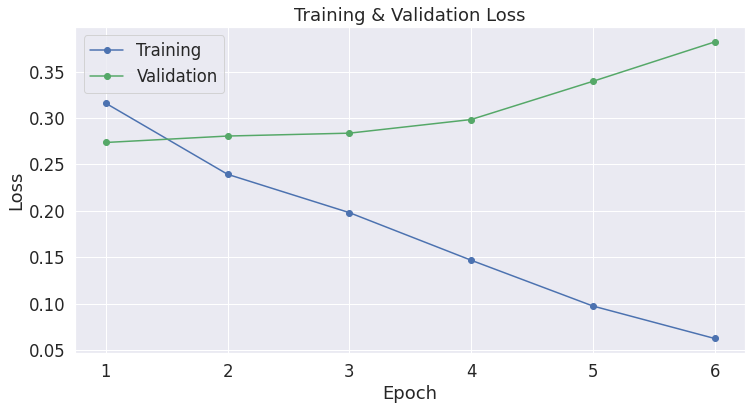

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

Some overfitting can be seen the in chart above. The reasons for why can be found in the paper submitted.

## Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

## Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'gdrive/MyDrive/dl/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to gdrive/MyDrive/dl/model_save/


('gdrive/MyDrive/dl/model_save/tokenizer_config.json',
 'gdrive/MyDrive/dl/model_save/special_tokens_map.json',
 'gdrive/MyDrive/dl/model_save/vocab.json',
 'gdrive/MyDrive/dl/model_save/merges.txt',
 'gdrive/MyDrive/dl/model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K gdrive/MyDrive/dl/model_save/

total 499775K
-rw------- 1 root root      1K Dec 19 22:36 added_tokens.json
-rw------- 1 root root      1K Dec 19 22:36 config.json
-rw------- 1 root root    446K Dec 19 22:36 merges.txt
-rw------- 1 root root 498448K Dec 19 22:36 pytorch_model.bin
-rw------- 1 root root      1K Dec 19 22:36 special_tokens_map.json
-rw------- 1 root root      1K Dec 19 22:36 tokenizer_config.json
-rw------- 1 root root    878K Dec 19 22:36 vocab.json


In [ ]:
!ls -l --block-size=M gdrive/MyDrive/dl/model_save/pytorch_model.bin

-rw------- 1 root root 487M Nov 24 01:17 gdrive/MyDrive/dl/model_save/pytorch_model.bin


In [ ]:
output_dir = 'gdrive/MyDrive/dl/model_save/'
# Copy the model files to a directory in your Google Drive.
!cp -r gdrive/MyDrive/dl/model_save/ $data_dir

# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

# Reinforcement Learning

In [ ]:
!pip install trl

In [ ]:
nlp = en_core_web_md.load()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##Load Data and Helper Functions

In [ ]:
#Load Top 1000 Common Nouns
filename = 'gdrive/MyDrive/dl/most-common-nouns-english.csv'
df = pd.read_csv(filename)
nouns = []
for index, row in df.iterrows():
    nouns.append(row['Word'])
    # print(row['Word'])
# print(nouns)

The get_guess_words function uses the datamuse api to return a list of guess words based on the provided definition (here analogy)

In [ ]:
# specify a word to pass the the analogy generator to produce 3 candidate analogies


def get_guess_words(analogy, word):
    first_analogy = analogy
    response = requests.get("https://api.datamuse.com/words?ml="+ first_analogy+"&max=25")
    ground_token = nlp(word)
    guess_acc = []
    guess_words = []
    for i, cand in enumerate(response.json()):
        guess_words.append(cand['word'])
        guess_token = nlp(guess_words[i])
        guess_acc.append(ground_token.similarity(guess_token))

    guess_acc = np.array(guess_acc)
    return guess_words, guess_acc, first_analogy


Use the NLTK library to find the top 5 synonyms for each word.

In [ ]:
def get_synonyms(word):
    syns = wordnet.synsets(word)[0:4]
    restricted_words = []
    restrict_words = set(chain.from_iterable([word.lemma_names() for word in syns]))
    for word in enumerate(restrict_words):
      restricted_words.append(word[1].replace("_", " "))
    return restricted_words

In [ ]:
#Return the best guess out of all the words guessed by datamuse
def best_guess(guess_words, guess_acc):
    best_guess = np.where(guess_acc == np.amax(guess_acc))
    best_guess = best_guess[0][0]
    return guess_words[best_guess], guess_acc[best_guess]


###Scoring Function

This is documented in detail in the submitted report but it effectively evaluates the quality of an analogy. If the analogy is close to the definition it is rewarded. If the analogy uses the words synonyms or is very long or short, it is penalized.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def score_function(word, analogy):
  syns = get_synonyms(word)
  syns.append(word)
  likes = ['like', 'such', 'as', 'similar']
  syn_occ = []
  like_occ = []
  ana_array = analogy.lower().split()
  try:
      for chunk in ana_array:
        syn_occ.append(syns.count(chunk))
        like_occ.append(likes.count(chunk))
      guess_words, guess_acc, first_analogy = get_guess_words(analogy, word)
      # print(guess_words, guess_acc)
      best_word, best_acc = best_guess(guess_words,guess_acc)

      score = (best_acc + guess_acc[0])*10  - np.sum(syn_occ)*2 + np.sum(like_occ)*3 - abs((len(ana_array)-30)/5)
  except ValueError:  #raised if `ana_array` is empty.
      score = - abs((len(ana_array)-30)/5)
      pass
  
  return score

##Load Model

Load the fine-tuned GPT2 model produced in the previos training step.

In [ ]:
# imports
import torch
from transformers import GPT2Tokenizer
from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch
from trl.ppo import PPOTrainer

output_dir = 'gdrive/MyDrive/dl/model_save/'

# get models

gpt2_model = GPT2HeadWithValueModel.from_pretrained(output_dir)
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(output_dir)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
gpt2_model.to(device)
gpt2_model_ref.to(device)

In [ ]:
!wandb login

wandb: Currently logged in as: cdb9619 (use `wandb login --relogin` to force relogin)


In [ ]:
import wandb
wandb.init(project="analogy", entity="cdb9619")

##Training
Batch and tokenize the data. Configure the PPOtrainer and set epochs to 4. 

In this section, we tried augmenting the training data to include 5 duplicates for each word to try and produce better results. We also trained without the duplicates and just commented out some of the code.

In [ ]:
###############################################
###############################################
#            MAIN RL SCRIPT                   #
#                 V2                          #
###############################################
###############################################

import time
import multiprocessing as mp
import gc
import os


queries_txt = []
batch_scores = []
batch_response = []
batch_queries = []
logs = dict()
timing = dict()

i = 0
epochs = 4
batch_size = 5

# initialize trainer
ppo_config = {'batch_size': batch_size, 'forward_batch_size': batch_size}
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **ppo_config)

def batch(a,bs):
    batches = []
    floor = len(a)//bs
    for i in range(0,floor):
        batches.append(a[i*bs:(i+1)*bs])
    if len(a)/bs > floor:
        batches.append(a[bs*floor:])
    return np.array(batches)

nouns_dup = []
for noun in nouns:
  for i in range(batch_size):
    nouns_dup.append(noun)

q_padded = ['<|startoftext|>' + noun + ': ' for noun in nouns_dup]

q_padded = gpt2_tokenizer(q_padded, padding=True, truncation=True, max_length=4, return_tensors="pt")
batches = batch(np.array(q_padded['input_ids']),batch_size)

del q_padded, nouns_dup
gc.collect()
batches = torch.from_numpy(batches).to(device)

for epoch in range(epochs):
    torch.cuda.empty_cache()
    logs = dict()
    timing = dict()
    t0 = time.time()

    for batch in batches:
        print(type(batch))
        responses = []
        t = time.time()

        responses = respond_to_batch(gpt2_model, batch, txt_len=50, top_k=50, top_p=0.95).to(device)
        timing['time/get_response'] = time.time() - t


        t = time.time()
        batch_response = []
        batch_queries = []
        scores = []
        for k in range(responses.shape[0]):
            query_txt = gpt2_tokenizer.decode(batch[k],skip_special_tokens=True)
            response_txt = gpt2_tokenizer.decode(responses[k],skip_special_tokens=True).replace("\n","")
            
            batch_response.append(response_txt)
            batch_queries.append(query_txt)
            del query_txt, response_txt
            gc.collect()
       
        ##Score Function
        ##Since this uses and api call, putting it into a pool process and speed it up
        pool = mp.Pool(processes=batch_size)
        scores = [pool.apply(score_function, args=(batch_queries[i], batch_response[i])) for i in range(len(batch_queries))]
        timing['time/scoring'] = time.time() - t
        pool.close()
        for i in range(len(batch_queries)):
          print('Score:',"{:.2f}".format(scores[i]), 'Data: ', batch_queries[i], batch_response[i])
        
        
        ####Reward function
        batch_scores.append(scores)
        rewards = torch.tensor(scores).to(device)
        # print(rewards.shape)

        ##UPDATING THE MODEL
        t = time.time()
        train_stats = ppo_trainer.step(batch, responses, rewards)
        timing['time/optimization'] = time.time()-t
        timing['time/batch'] = time.time()-t0
        # # print(train_stats)
        print('UPDATED MODEL')


        table_rows = [list(r) for r in zip(batch_queries, batch_response, batch_scores)]
        logs.update({'analogy_batch':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
        logs.update(timing)
        logs.update(train_stats)
        logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
        logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
        logs['env/reward_dist'] = rewards.cpu().numpy()
        wandb.log(logs)

        
        del rewards, batch_response, batch_queries, responses
        gc.collect()


Streaming output truncated to the last 5000 lines.
UPDATED MODEL
<class 'torch.Tensor'>
Score: 8.19 Data:  belief:  1. Knowledge of one's self or feelings; consciousness of one's own feelings, purposes, and intentions; capacity to assist one's self in determining the feelings of one's self, temper, and the duties we are to accomplish. 2. A
Score: 10.77 Data:  belief:  1. Care and attention; careful application; as, to lead one in faith; to lead a way or phrase, persuasion, or instruction. The devout believers receive the light, and the gospel as the means of salvation. Law.An
Score: 6.55 Data:  belief:  1. Knowledge of one's self; consciousness; capacity to judge and judge the causes and effects of a cause. 2. The act of reading, or the state of being read; as, the eyes of a man.
Score: 10.41 Data:  belief:  1. The act offaith; devotion; esp., that which is sincerely pious, or in behalf of the religion; devotion to God, as the daily subject of religion. 2. That which is sincerely pious

##Save the RL Model

In [ ]:
##Save the RL Model

output_dir_rl = 'gdrive/MyDrive/dl/rl_model/'

# Create output directory if needed
if not os.path.exists(output_dir_rl):
    os.makedirs(output_dir_rl)

print("Saving model to %s" % output_dir_rl)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(gpt2_model, 'module') else gpt2_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir_rl)
gpt2_tokenizer.save_pretrained(output_dir_rl)


Saving model to gdrive/MyDrive/dl/rl_model/


('gdrive/MyDrive/dl/rl_model/tokenizer_config.json',
 'gdrive/MyDrive/dl/rl_model/special_tokens_map.json',
 'gdrive/MyDrive/dl/rl_model/vocab.json',
 'gdrive/MyDrive/dl/rl_model/merges.txt',
 'gdrive/MyDrive/dl/rl_model/added_tokens.json')